In [31]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from sympy import *

# 1


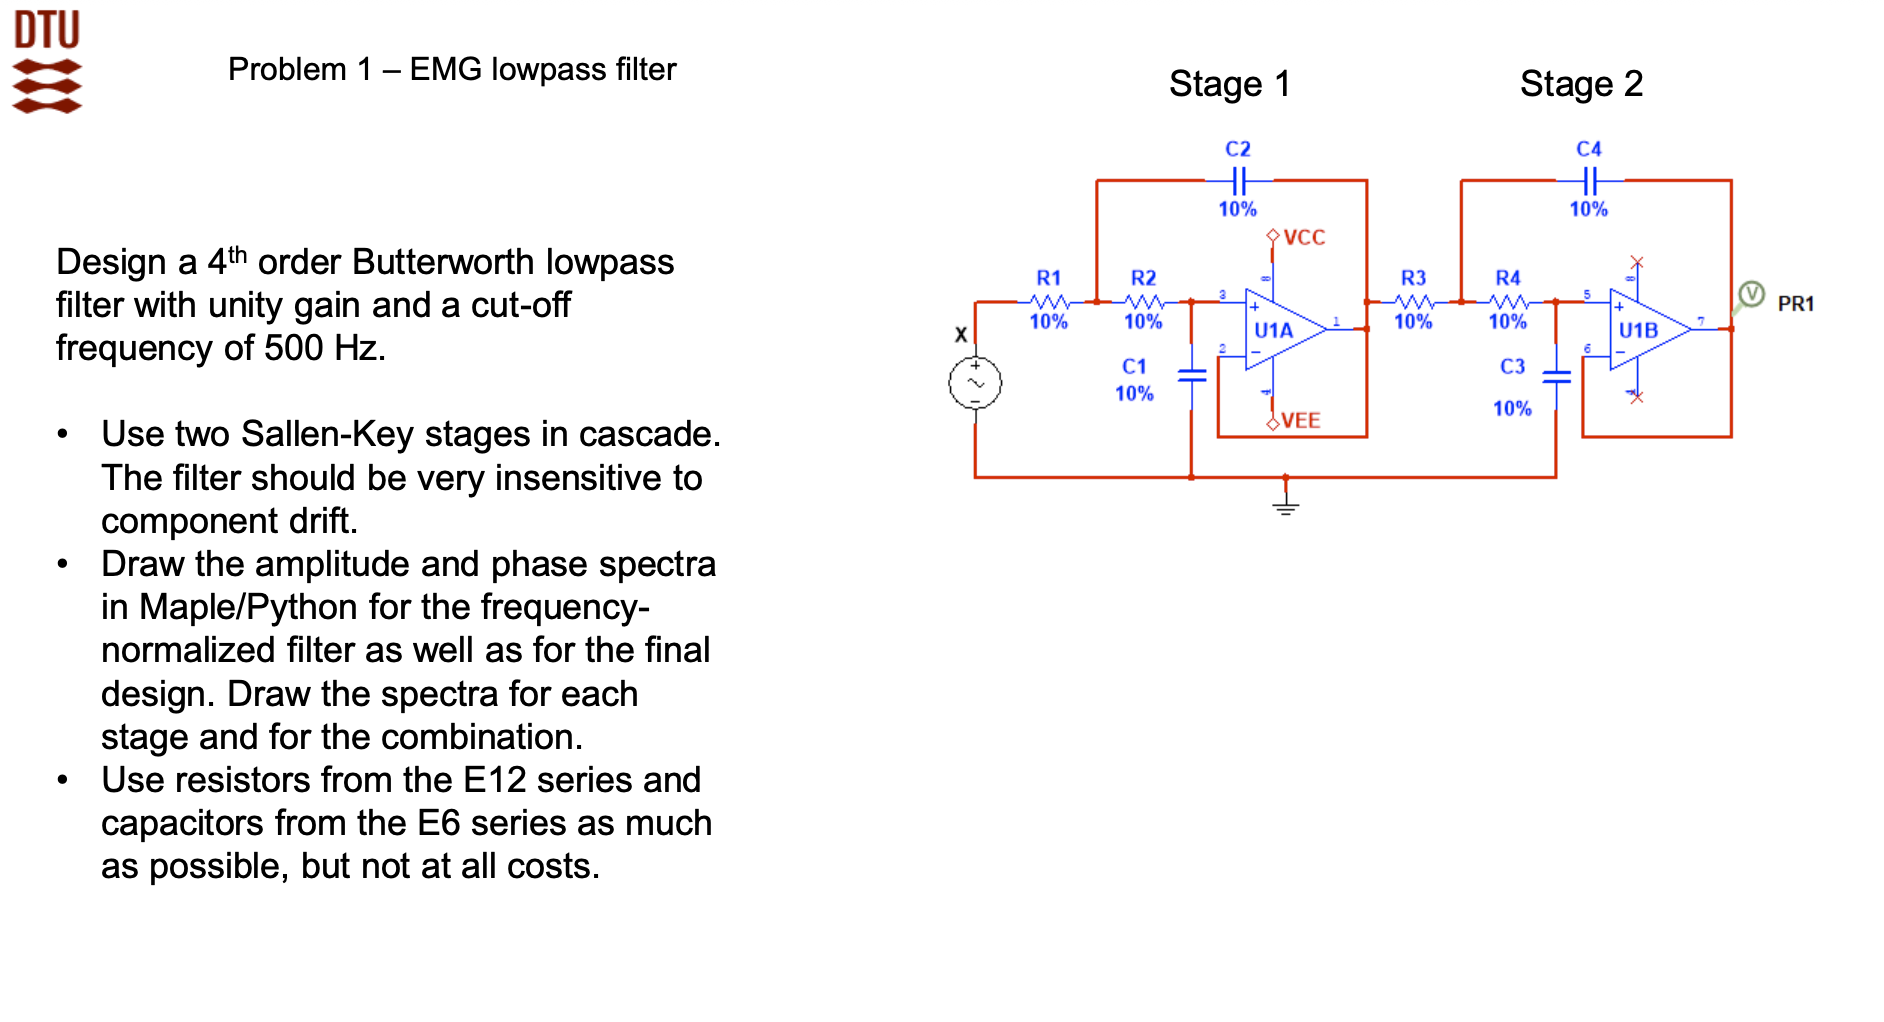

In [32]:
def butterworth_min_order(Gp, Gs, wp, ws):
    
    #Calculate the minimum order of a Butterworth filter.
    #
    # Parameters:
    # Gp -- gain at passband edge (linear, not dB)
    # Gs -- gain at stopband edge (linear, not dB)
    # wp -- passband frequency (rad/s)
    # ws -- stopband frequency (rad/s)
    # 
    # Returns:
    # n -- minimum order (rounded up to nearest integer)

    numerator = math.log10((1 / Gs**2 - 1) / (1 / Gp**2 - 1))
    denominator = 2 * math.log10(ws / wp)
    n = math.ceil(numerator / denominator)
    return n

# Example usage:
Gp = 0.891  # corresponds to -1 dB
Gs = 0.177  # corresponds to -15 dB
wp = 1      # rad/s
ws = 2      # rad/s

n = butterworth_min_order(Gp, Gs, wp, ws)
print(f"Minimum Butterworth filter order: n = {n}")


Minimum Butterworth filter order: n = 4


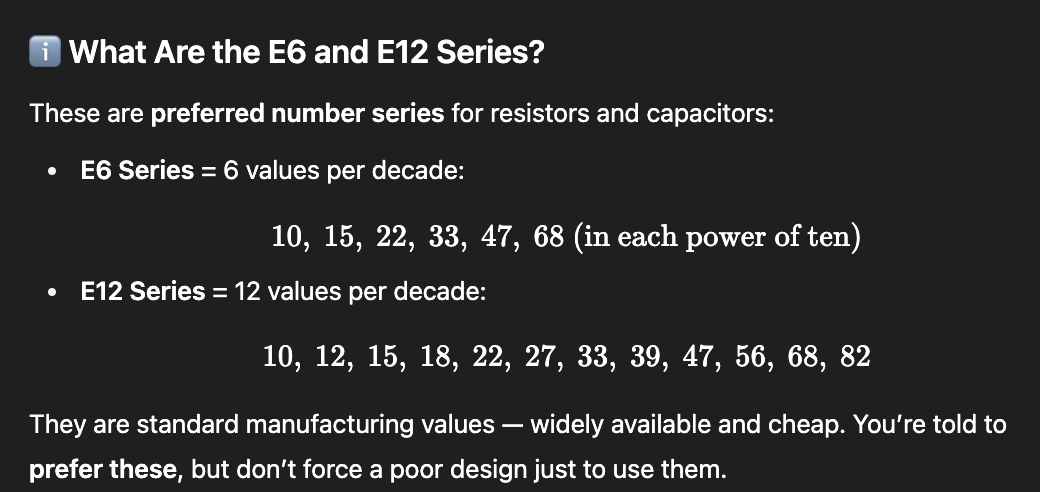

In [33]:
# Define Butterworth 4th-order stage coefficients
stages = [
    {"stage": "Stage 1", "a1": 1.84776, "a0": 1.0},
    {"stage": "Stage 2", "a1": 0.765367, "a0": 1.0}
]

# Cut-off frequency
fc = 500  # Hz
wc = 2 * pi * fc  # rad/s

# Preferred values (in nanofarads and kilo-ohms)
E6_caps_nF = np.array([10, 15, 22, 33, 47, 68])
E12_res_kOhm = np.array([10, 12, 15, 18, 22, 27, 33, 39, 47, 56, 68, 82])

# Prepare results
results = []

for stage in stages:
    stage_name = stage["stage"]
    a1 = stage["a1"]
    a0 = stage["a0"]
    
    for C2_nF in E6_caps_nF:
        C2 = C2_nF * 1e-9
        C1 = C2 * (a1**2) / (4 * a0)
        
        R_ideal = 1 / (wc * sqrt(C1 * C2))
        
        # Find closest E12 resistor value
        R_closest = min(E12_res_kOhm, key=lambda r: abs(r * 1e3 - R_ideal))
        R_error_percent = abs((R_closest * 1e3 - R_ideal) / R_ideal) * 100
        
        results.append({
            "Stage": stage_name,
            "C2 (nF)": C2_nF,
            "C1 (nF)": round(C1 * 1e9, 2),
            "R_ideal (kΩ)": round(R_ideal / 1e3, 3),
            "R_E12 (kΩ)": R_closest,
            "Error (%)": round(R_error_percent, 2)
        })

df = pd.DataFrame(results)
display(df)


Stage  C2 (nF)  C1 (nF) R_ideal (kΩ)  R_E12 (kΩ) Error (%)
0   Stage 1       10     8.54       34.454          33      4.22
1   Stage 1       15    12.80       22.969          22      4.22
2   Stage 1       22    18.78       15.661          15      4.22
3   Stage 1       33    28.17       10.440          10      4.22
4   Stage 1       47    40.12        7.331          10     36.42
5   Stage 1       68    58.04        5.067          10     97.37
6   Stage 2       10     1.46       83.178          82      1.42
7   Stage 2       15     2.20       55.452          56      0.99
8   Stage 2       22     3.22       37.808          39      3.15
9   Stage 2       33     4.83       25.206          27      7.12
10  Stage 2       47     6.88       17.698          18      1.71
11  Stage 2       68     9.96       12.232          12      1.90

## plotting

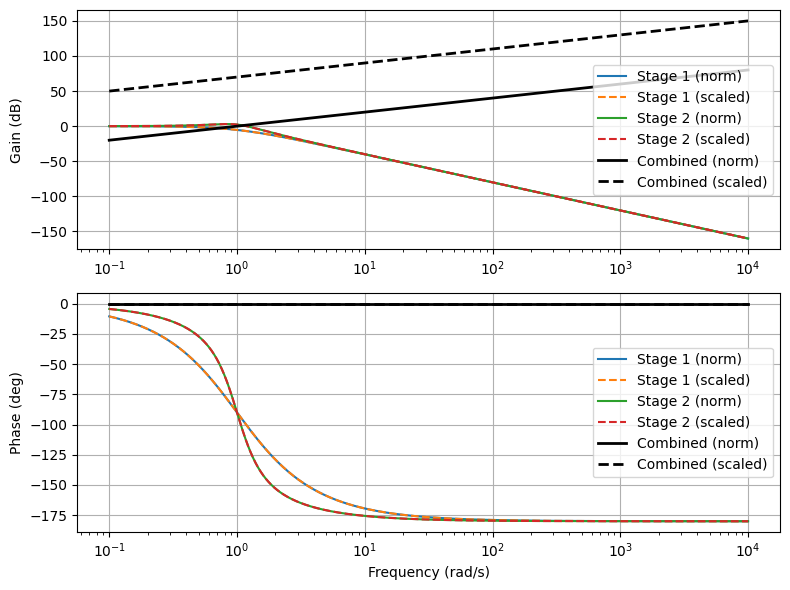

In [ ]:
# Butterworth coefficients for both stages
a1_1, a0_1 = 1.84776, 1.0
a1_2, a0_2 = 0.765367, 1.0

# Frequency range
w = np.logspace(-1, 4, 1000)
wc = 2 * np.pi * 500  # 500 Hz cutoff

# Normalized and scaled transfer functions
def tf(a1, a0): return [1], [1, a1, a0]
def tf_scaled(a1, a0, wc): return [wc**2], [1, a1*wc, a0*wc**2]

# Compute frequency responses
def get_response(a1, a0, scaled=False):
    if scaled:
        num, den = tf_scaled(a1, a0, wc)
        freq = w * wc
    else:
        num, den = tf(a1, a0)
        freq = w
    _, h = signal.freqs(num, den, worN=freq)
    return 20 * np.log10(abs(h)), np.angle(h, deg=True)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
for label, a1, a0 in [("Stage 1", a1_1, a0_1), ("Stage 2", a1_2, a0_2)]:
    mag, phase = get_response(a1, a0)
    mag_s, phase_s = get_response(a1, a0, scaled=True)
    ax1.plot(w, mag, label=f"{label} (norm)")
    ax1.plot(w, mag_s, '--', label=f"{label} (scaled)")
    ax2.plot(w, phase, label=f"{label} (norm)")
    ax2.plot(w, phase_s, '--', label=f"{label} (scaled)")

# Combined response
num1, den1 = tf(a1_1, a0_1)
num2, den2 = tf(a1_2, a0_2)
mag_c, phase_c = freqs([1], np.convolve(den1, den2), worN=w)
ax1.plot(w, 20*np.log10(abs(mag_c)), 'k', linewidth=2, label="Combined (norm)")
ax2.plot(w, np.angle(mag_c, deg=True), 'k', linewidth=2, label="Combined (norm)")

num1s, den1s = tf_scaled(a1_1, a0_1, wc)
num2s, den2s = tf_scaled(a1_2, a0_2, wc)
mag_cs, phase_cs = freqs([wc**4], np.convolve(den1s, den2s), worN=w*wc)
ax1.plot(w, 20*np.log10(abs(mag_cs)), 'k--', linewidth=2, label="Combined (scaled)")
ax2.plot(w, np.angle(mag_cs, deg=True), 'k--', linewidth=2, label="Combined (scaled)")

# Finalize plot
for ax in [ax1, ax2]:
    ax.set_xscale('log')
    ax.legend()
    ax.grid(True)
ax1.set_ylabel("Gain (dB)")
ax2.set_ylabel("Phase (deg)")
ax2.set_xlabel("Frequency (rad/s)")
plt.tight_layout()
plt.show()
